# 03 — Exploratory Analysis & Visualization

This notebook explores spatial patterns in brewery accessibility and median home values
across Philadelphia census tracts. Using the cleaned, tract-level dataset created in
Notebook 2, we examine geographic variation, bivariate relationships, and accessibility
threshold effects.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

In [2]:
gdf = gpd.read_file("../data/processed/philly_tracts_final.geojson")

In [3]:
gdf.columns
gdf.shape

(376, 22)

## Median home values choropleth

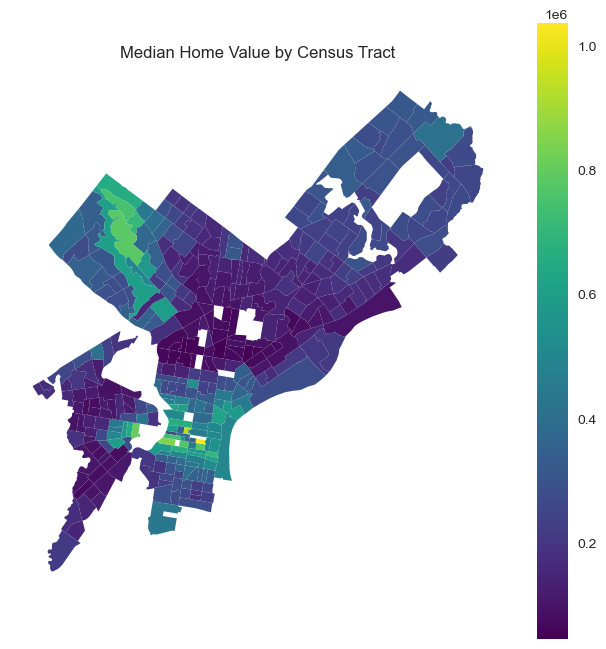

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

gdf.plot(
    column="med_home_val",
    cmap="viridis",
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("Median Home Value by Census Tract")
ax.axis("off")
plt.show()

## Distance to nearest brewery

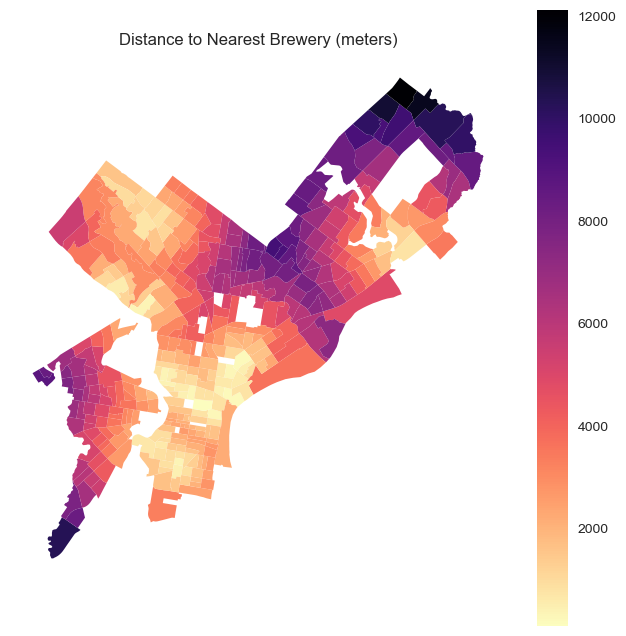

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

gdf.plot(
    column="dist_to_brewery_m",
    cmap="magma_r",
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("Distance to Nearest Brewery (meters)")
ax.axis("off")
plt.show()

## Non Spatial EDA (Distributions)

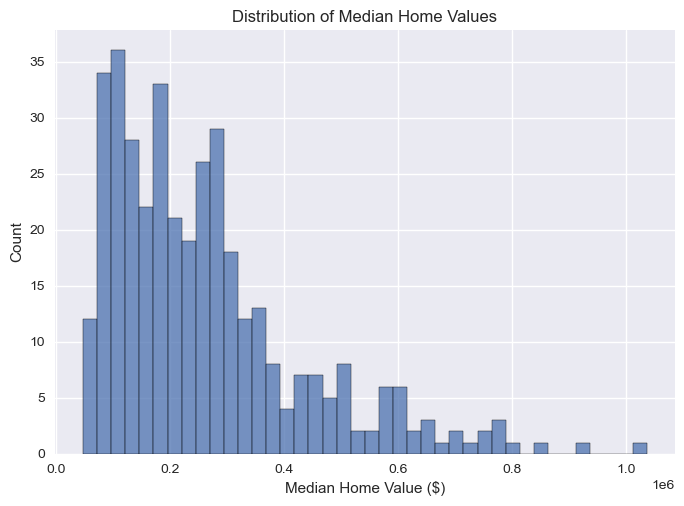

In [6]:
sns.histplot(gdf["med_home_val"], bins=40)
plt.title("Distribution of Median Home Values")
plt.xlabel("Median Home Value ($)")
plt.show()


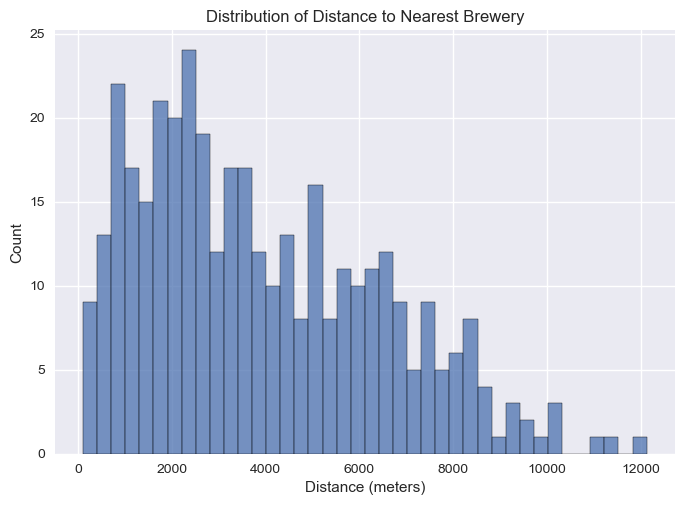

In [7]:
sns.histplot(gdf["dist_to_brewery_m"], bins=40)
plt.title("Distribution of Distance to Nearest Brewery")
plt.xlabel("Distance (meters)")
plt.show()


## Bivariate Relationships

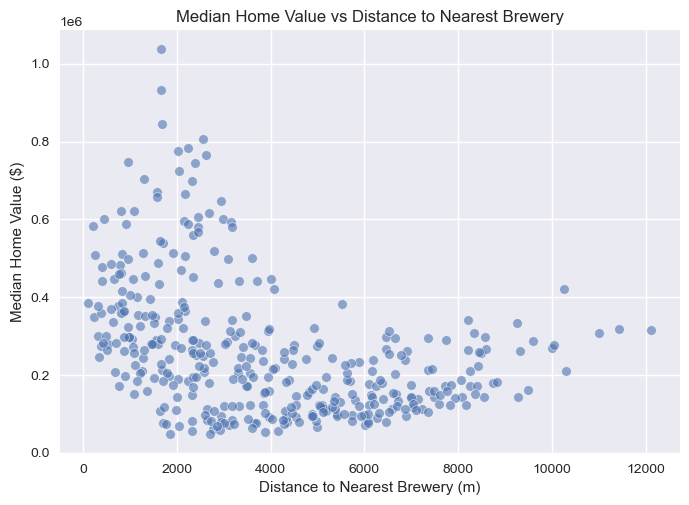

In [8]:
sns.scatterplot(
    data=gdf,
    x="dist_to_brewery_m",
    y="med_home_val",
    alpha=0.6
)

plt.title("Median Home Value vs Distance to Nearest Brewery")
plt.xlabel("Distance to Nearest Brewery (m)")
plt.ylabel("Median Home Value ($)")
plt.show()


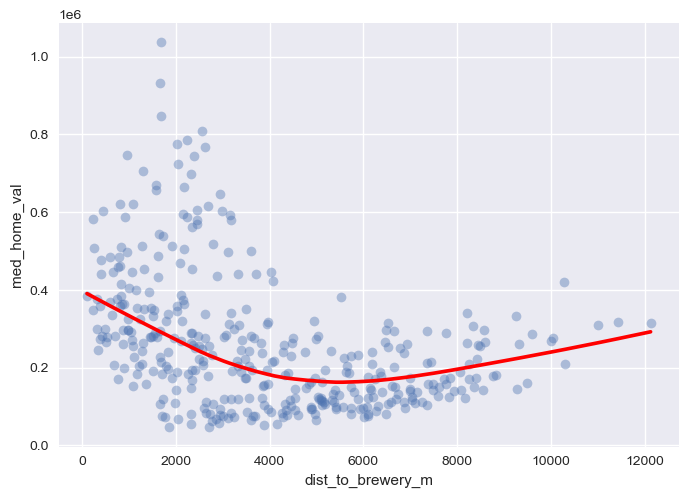

In [9]:
sns.regplot(
    data=gdf,
    x="dist_to_brewery_m",
    y="med_home_val",
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"},
    lowess=True
)
plt.show()


## Threshhold analysis

In [10]:
gdf["walkable_800m"] = gdf["brewery_within_800m"].map({1: "≤800m", 0: ">800m"})

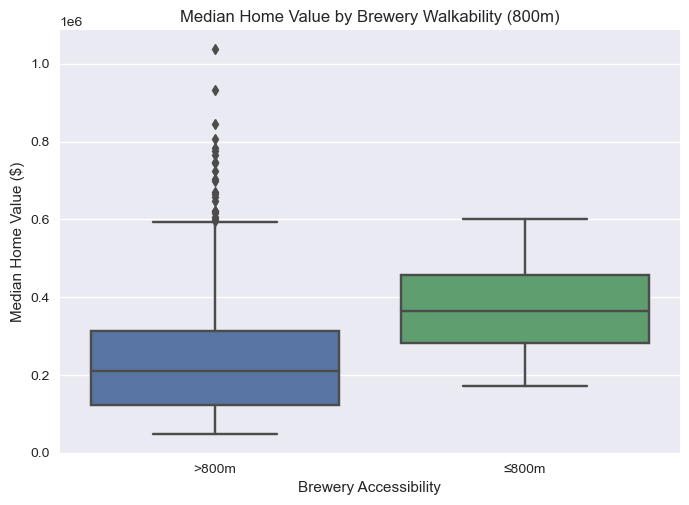

In [11]:
sns.boxplot(
    data=gdf,
    x="walkable_800m",
    y="med_home_val"
)

plt.title("Median Home Value by Brewery Walkability (800m)")
plt.xlabel("Brewery Accessibility")
plt.ylabel("Median Home Value ($)")
plt.show()


## Brewery intensity effects

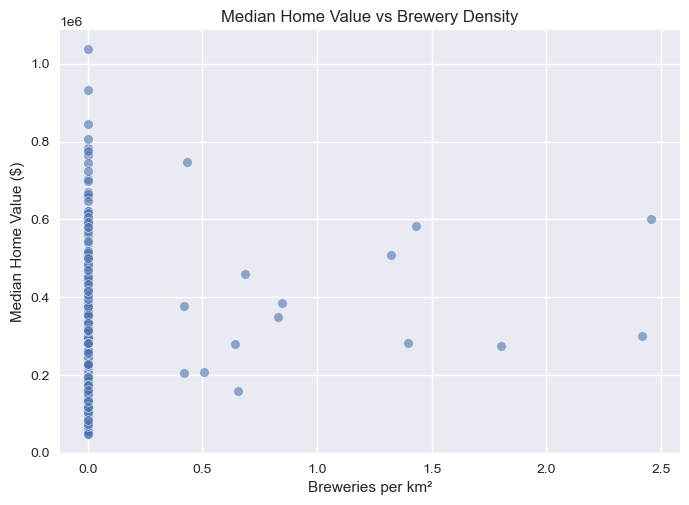

In [12]:
sns.scatterplot(
    data=gdf,
    x="brewery_density",
    y="med_home_val",
    alpha=0.6
)

plt.title("Median Home Value vs Brewery Density")
plt.xlabel("Breweries per km²")
plt.ylabel("Median Home Value ($)")
plt.show()

In [ ]:
## Interactive Map: Breweries and Nearby Home Values

In [18]:
import folium
import numpy as np

# Load processed tracts
gdf = gpd.read_file("../data/processed/philly_tracts_final.geojson")

# Load breweries
gdf_brew = gpd.read_file("../data/raw/breweries_philly.geojson")
gdf_brew = gdf_brew.dropna(subset=["geometry"])
gdf_brew = gdf_brew[gdf_brew["brewery_type"].isin(["micro", "brewpub", "regional"])]

# Ensure CRS
gdf = gdf.to_crs(4326)
gdf_brew = gdf_brew.to_crs(4326)


In [19]:
# Project to meters for buffering
tracts_m = gdf.to_crs(3857).copy()
brews_m = gdf_brew.to_crs(3857).copy()

# Use tract centroids for walkability
tracts_m["centroid"] = tracts_m.geometry.centroid

R = 800  # walkable radius in meters

brew_stats = []

for idx, brew in brews_m.iterrows():
    buf = brew.geometry.buffer(R)
    nearby = tracts_m[tracts_m["centroid"].within(buf)]

    brew_stats.append({
        "brew_index": idx,
        "n_tracts_800m": len(nearby),
        "median_home_800m": nearby["med_home_val"].median(),
        "mean_home_800m": nearby["med_home_val"].mean(),
    })

brew_stats = (
    gpd.GeoDataFrame(brew_stats)
    .set_index("brew_index")
)

gdf_brew = gdf_brew.join(brew_stats)


In [20]:
# Initialize map
m = folium.Map(
    location=[39.9526, -75.1652],
    zoom_start=12,
    tiles="CartoDB positron"
)

# Add tract-level choropleth (median home value)
folium.Choropleth(
    geo_data=gdf,
    data=gdf,
    columns=["GEOID", "med_home_val"],
    key_on="feature.properties.GEOID",
    fill_color="YlGnBu",
    fill_opacity=0.6,
    line_opacity=0.1,
    nan_fill_color="lightgray",
    legend_name="Median Home Value ($)"
).add_to(m)


In [21]:
for _, row in gdf_brew.iterrows():
    lat, lon = row.geometry.y, row.geometry.x

    popup_html = f"""
    <b>{row.get('name','Brewery')}</b><br>
    Type: {row.get('brewery_type','')}<br><br>
    <b>Within 800m</b><br>
    Tracts: {int(row.get('n_tracts_800m',0))}<br>
    Median home value: ${row.get('median_home_800m',np.nan):,.0f}<br>
    Mean home value: ${row.get('mean_home_800m',np.nan):,.0f}
    """

    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        fill=True,
        fill_opacity=0.85,
        color="#8c2d04",
        tooltip=row.get("name","Brewery"),
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)


In [24]:
m
m.save("brewery_home_value_interactive.html")

In [25]:
gdf[["med_home_val", "dist_to_brewery_m", "brewery_density", "brewery_count"]].corr()


,med_home_val,dist_to_brewery_m,brewery_density,brewery_count
med_home_val,1.000000,-0.392675,0.137110,0.143154
dist_to_brewery_m,-0.392675,1.000000,-0.234798,-0.259107
brewery_density,0.137110,-0.234798,1.000000,0.885110
brewery_count,0.143154,-0.259107,0.885110,1.000000


In [26]:
import statsmodels.api as sm

df = gdf.dropna(subset=["med_home_val", "dist_to_brewery_m"])

X = sm.add_constant(df["dist_to_brewery_m"])
y = df["med_home_val"]

model = sm.OLS(y, X).fit()
model.rsquared


0.15419401468718752